In [1]:
#参考：https://www.kaggle.com/bertcarremans/data-preparation-exploration
#文章的目的是对数据进行探索性分析，确定数据预处理方式

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
train = pd.read_csv('/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input//train.csv')
test = pd.read_csv('/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input//test.csv')

比赛官方数据介绍：

* 相同语义类型的特征名字上会打相同的tag (e.g., ind, reg, car, calc).
* 特征名字以bin结尾表示二值型特征，以cat结尾表示类别型特征，其他则表示连续型、次序型特征.
* 特征缺失时使用了-1填充.
* target列表示预测目标，即，是否索赔.

In [5]:
print train.shape
train.drop_duplicates()
print train.shape
print test.shape

(595212, 59)
(595212, 59)
(892816, 58)


train 没有重复行

In [6]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

由于缺失值使用-1填充，所以各个字段没有null值


在特征方面，train数据集中有59个字段，除了id和target，包含特征57个：

* 相似特征会用相同的tag标识：
	* ind, 18个
	* reg,3个
	* car,16个
	* calc,20个
* 不同类型特征：
	* 后缀为bin，表示bool特征，17个；
	* cat表示类别特征，14个；
	* 没有这些后缀的特征为连续型特征，29个；

可以使用14个类别特征构建哑变量

# 元数据

* role: input, ID, target
* level: nominal, interval, ordinal, binary
* keep: True or False
* dtype: int, float, str

In [7]:
data = []
for f in train.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    
    # Defining the data type 
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [8]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [9]:
# Example to extract all nominal variables that are not dropped
meta[(meta.level == 'nominal') & (meta.keep)].index

Index([u'ps_ind_02_cat', u'ps_ind_04_cat', u'ps_ind_05_cat', u'ps_car_01_cat',
       u'ps_car_02_cat', u'ps_car_03_cat', u'ps_car_04_cat', u'ps_car_05_cat',
       u'ps_car_06_cat', u'ps_car_07_cat', u'ps_car_08_cat', u'ps_car_09_cat',
       u'ps_car_10_cat', u'ps_car_11_cat'],
      dtype='object', name=u'varname')

In [10]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


# 描述性统计

In [11]:
#区间变量
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


reg变量

* 只有ps_reg_03含有缺失值
* 各个变量的区间（最大最小值）不同，可以做scaling，后续根据具体分类算法灵活确定选择归一化方法.

car变量

* ps_car_12 、 ps_car_15 含有缺失值
* 同上，也有归一化的必要性

calc变量

* 没有缺失值
* 最大值都是0.9，可以利用maxscaling做归一化
* 三个calc变量的分布相同

从数据来看，特征的取值范围都很小，可能是在匿名化的过程中做了一些特征变换（e.g. log）


In [12]:
#顺序性变量

v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000



* 只有ps_car_11存在缺失值
* 可以使用不同的range对不同的特征进行scaling

In [13]:
#二值型变量
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* 训练数据集中target只有3.645%为正样本，存在严重的不平衡问题.
* 从mean值可以看出，大部分特征取值以0为主

# 解决样本不均衡问题

从上面可以看出，正负样本不平衡问题十分严重。如果不作处理直接训练，会引起准确率很高，但是没有任何的价值，和比赛的评价标准也是不匹配的。解决办法有两种：

* 对target=1的样本做过采样；
* 对target=0的样本做欠采样；

比赛用的样本较多，可以先用欠采样尝试：


In [14]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)
print "train 结构：",train.shape

Rate to undersample records with target=0: 0.340435696874
Number of records with target=0 after undersampling: 195246
train 结构： (216940, 59)


# 数据质量检查

## 缺失值检查

In [15]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = float(missings)/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values



* ps_car_03_cat 、 ps_car_05_cat 含有大量缺失值，将缺失值剔除.
* 针对其他类别型特征，保持-1不变即可；
* ps_reg_03 (continuous) 18% 记录含有缺失值，使用均值填充；
* ps_car_11 (ordinal) 5行记录含有缺失值，使用均值填充；
* ps_car_12 (continuous) 只有1行记录含有缺失值，使用均值填充；
* ps_car_14 (continuous) 7%的记录含有缺失值，使用均值填充；

In [16]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop),'keep'] = False  # Updating the meta

# Imputing with the mean or mode
mean_imp = Imputer(missing_values=-1, strategy='mean', axis=0)
mode_imp = Imputer(missing_values=-1, strategy='most_frequent', axis=0)
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

## 处理类别特征

In [17]:

v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values



* ps_car_11_cat取值范围比较多，有104种取值，直接转为哑变量使用存在变量过多的问题，可以采用的一种方法是统计各个类别包含的正样本占比，将类别变量转为连续型变量

In [18]:
cat_perc = train[['ps_car_11_cat', 'target']].groupby(['ps_car_11_cat'],as_index=False).mean()
cat_perc.rename(columns={'target': 'ps_car_11_cat_tm'}, inplace=True)
train = pd.merge(train, cat_perc, how='inner', on='ps_car_11_cat')
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta

# 数据可视化

## 类别特征可视化

查看各个类别变量，包含target=1的比例

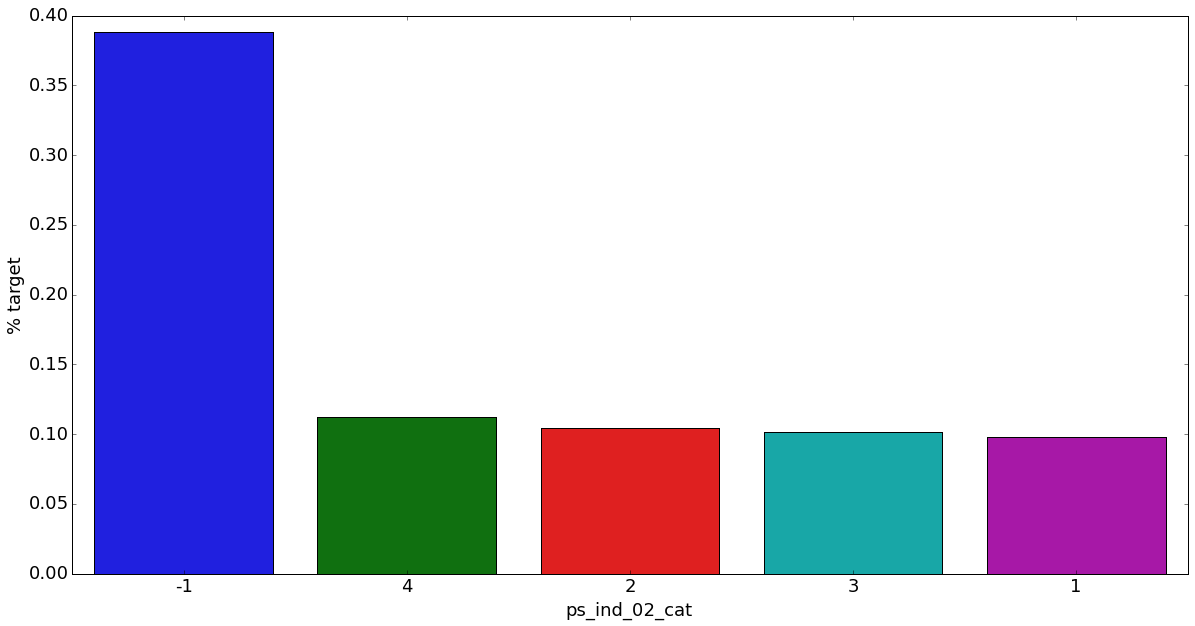

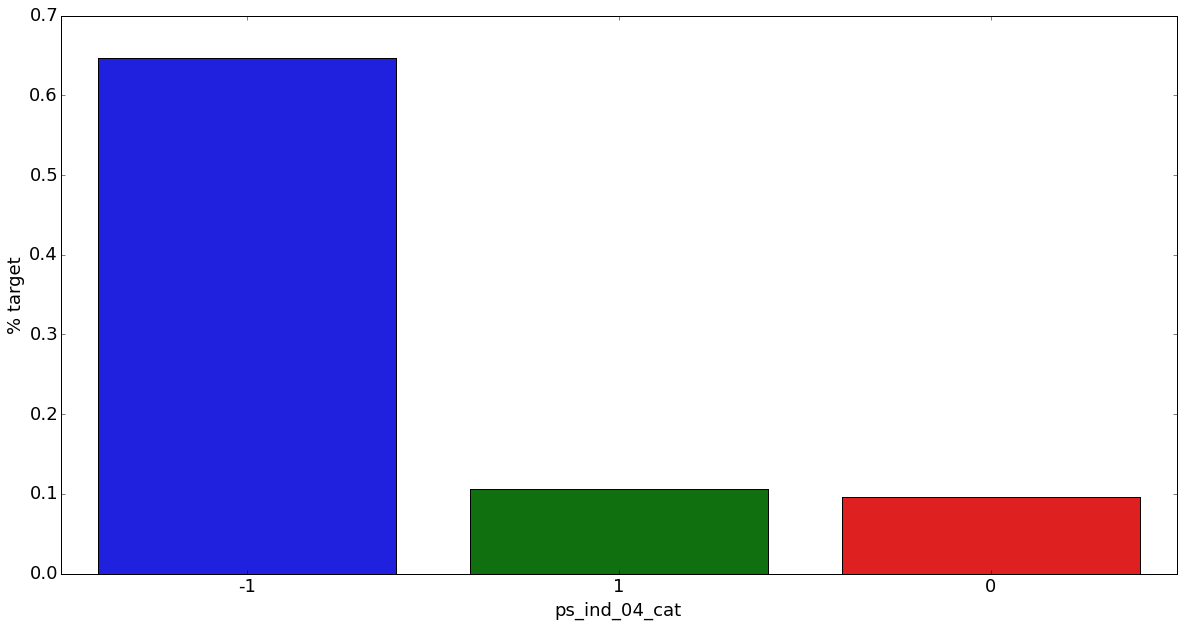

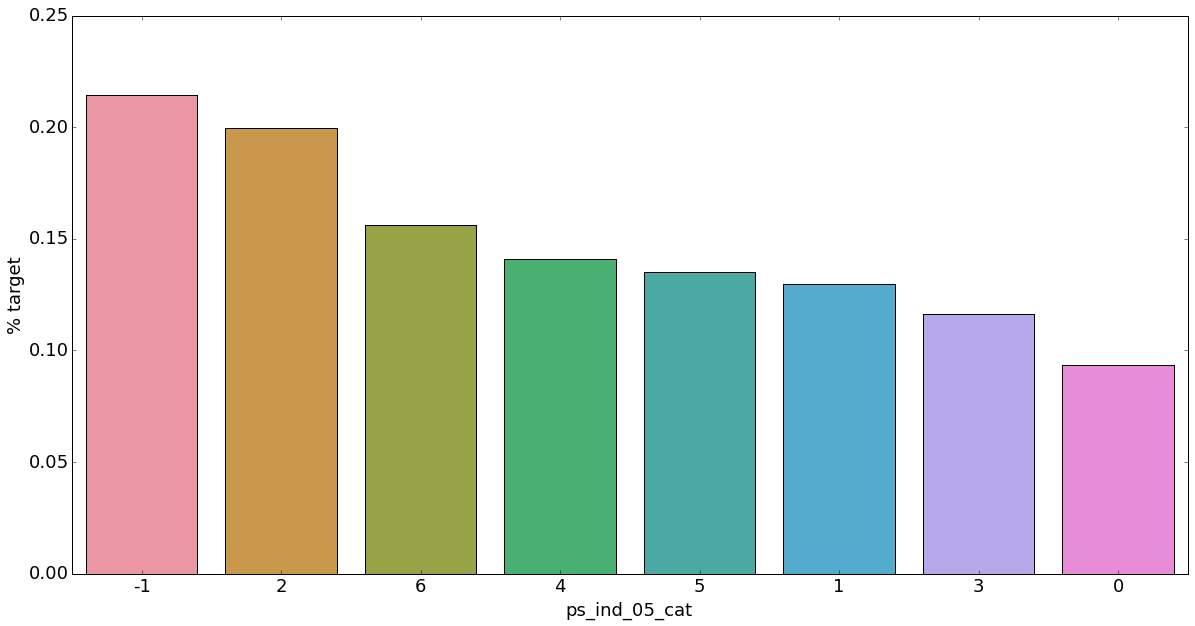

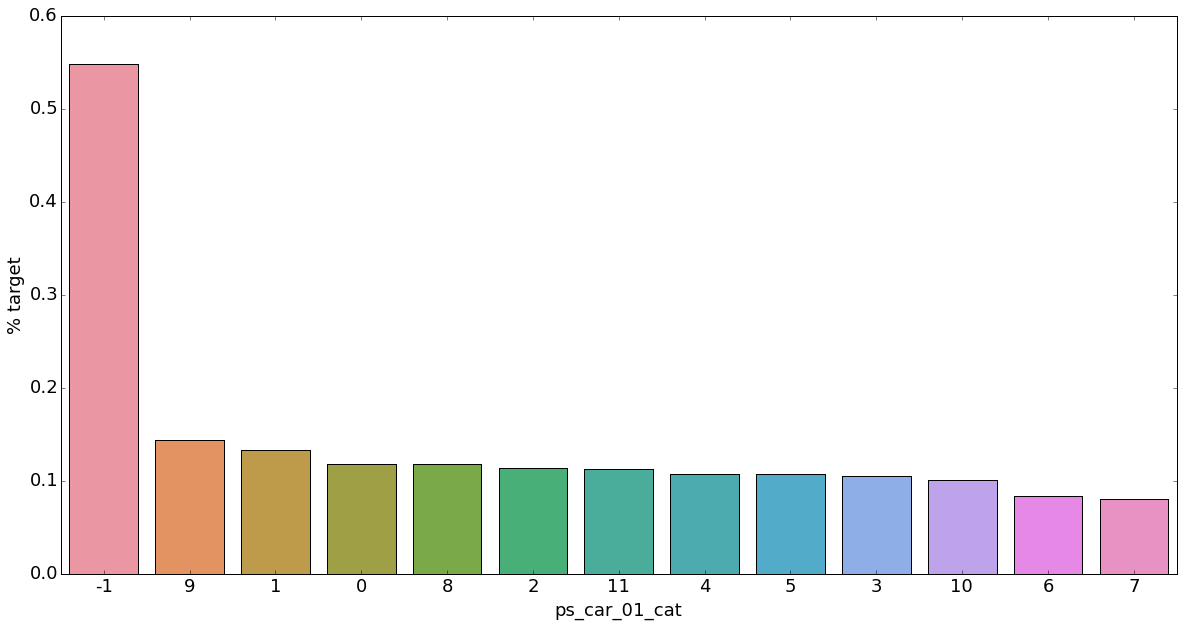

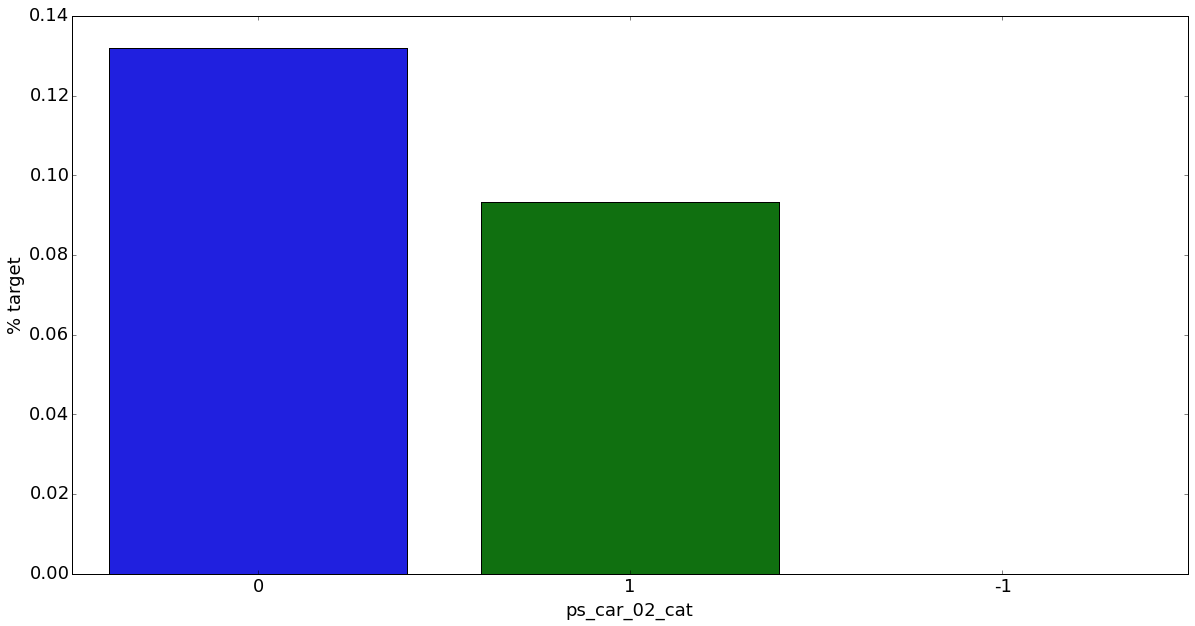

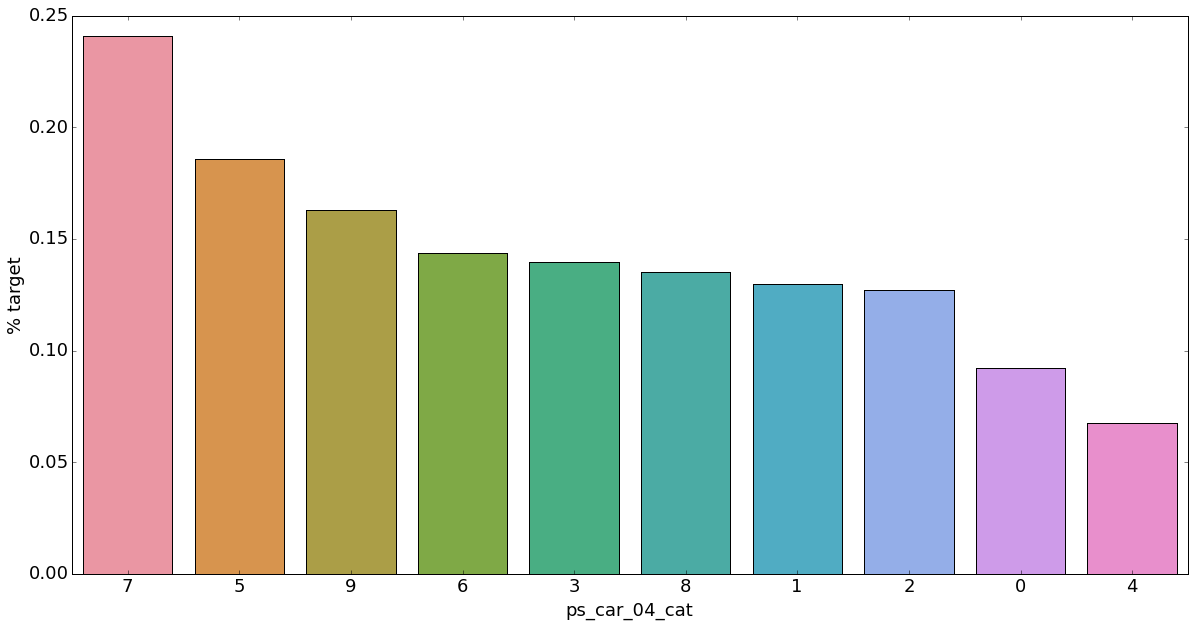

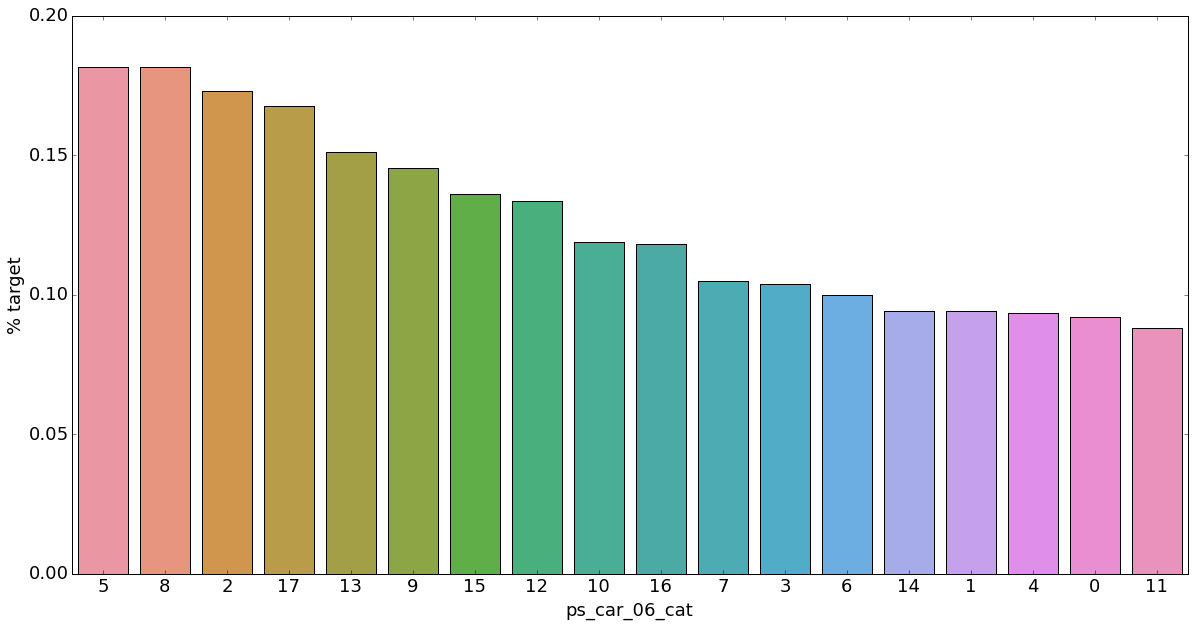

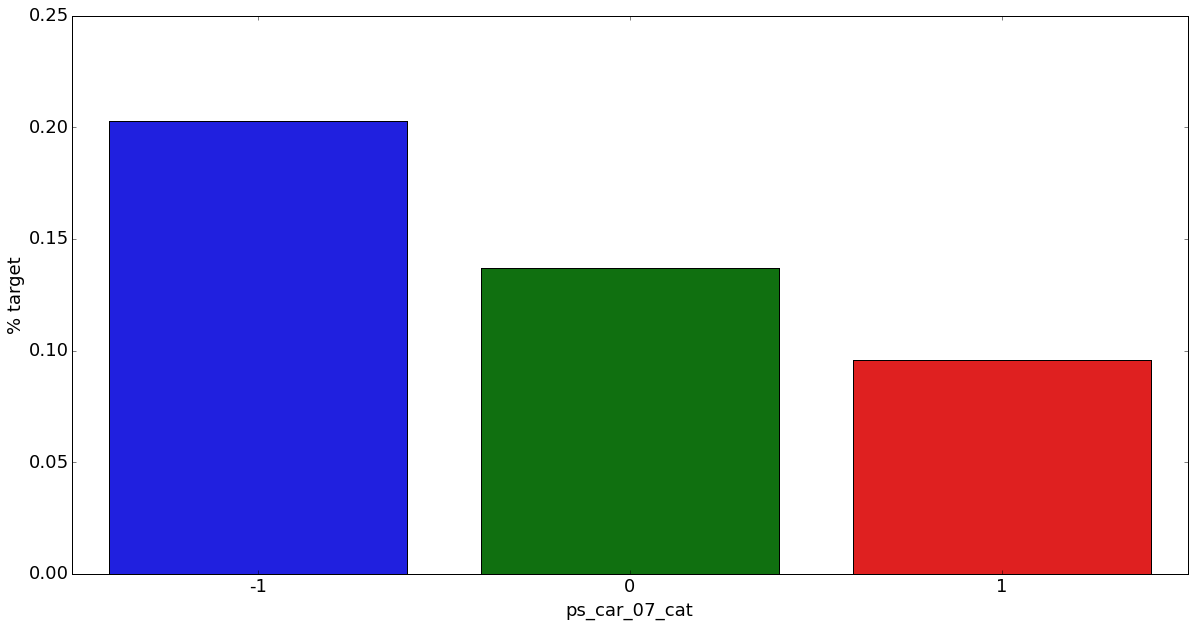

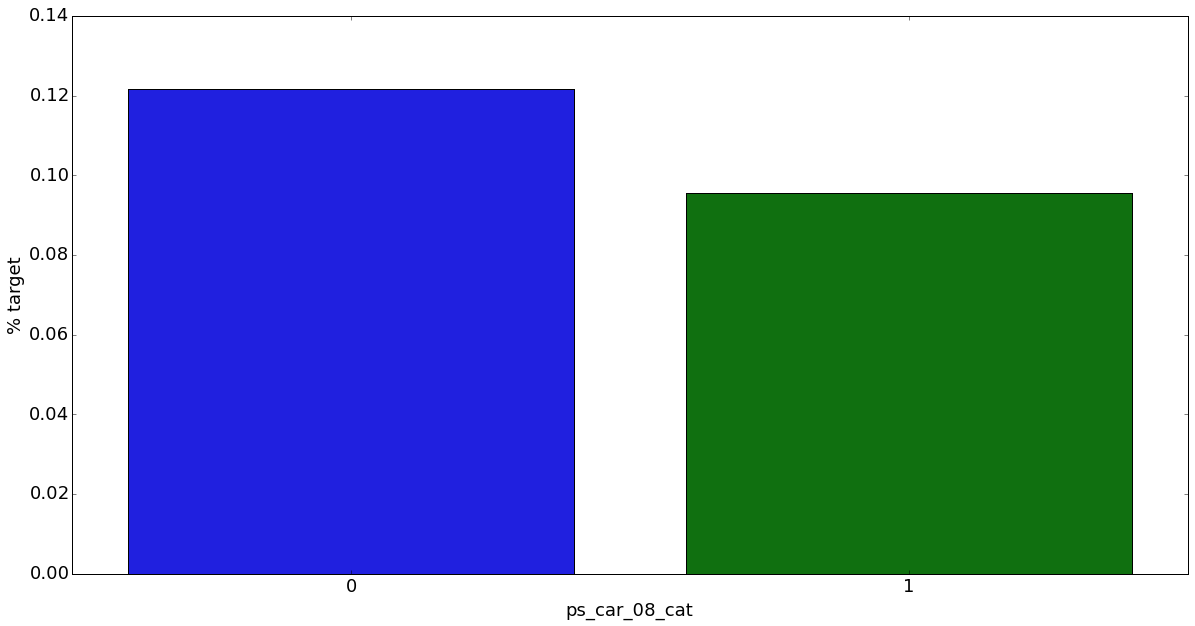

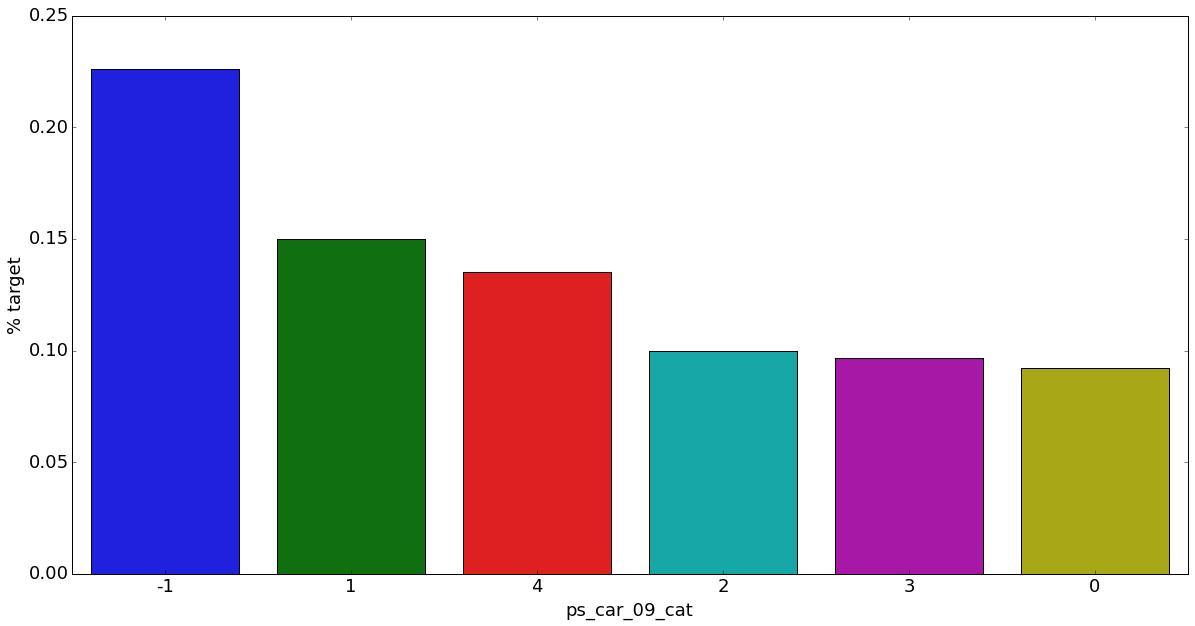

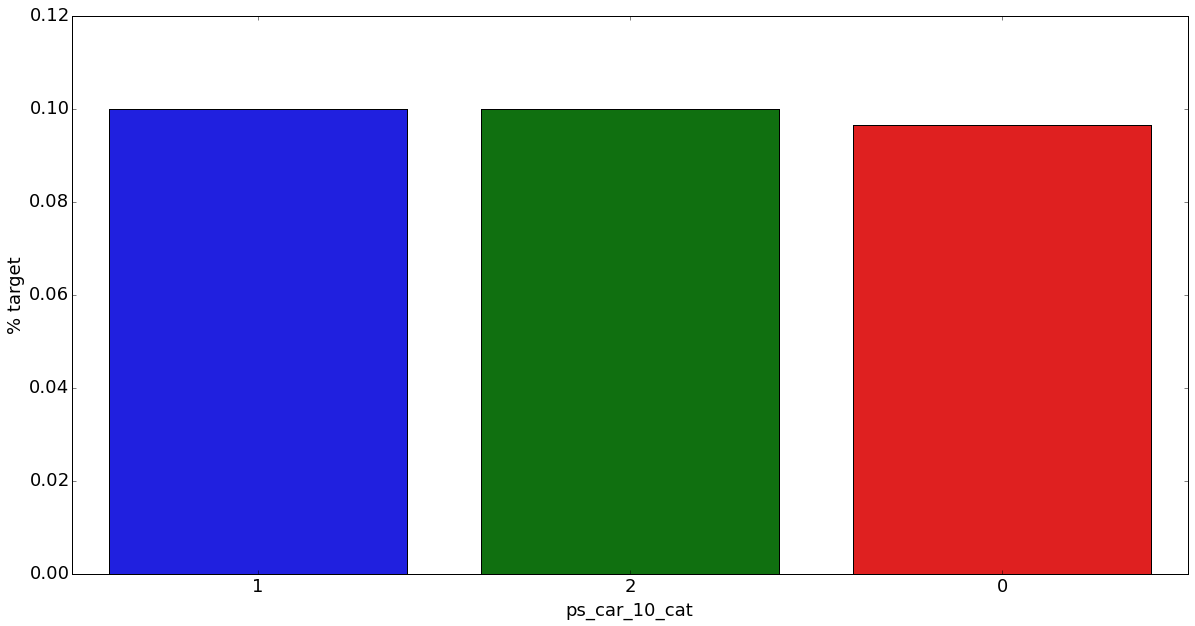

In [19]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

从图上来看，变量中-1能够很好地区别于其他取值，所以，-1值不需要填充。

## 连续型特征可视化
利用热力图查看变量之间的相关性

/Library/Python/2.7/site-packages/matplotlib-override/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


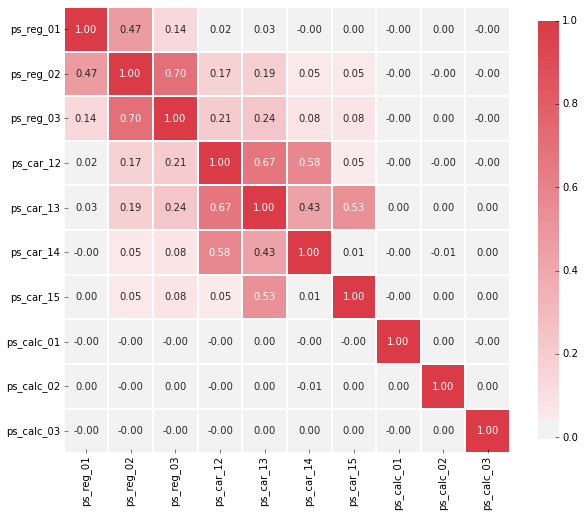

In [20]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

以下变量之间具有很高的相关性:

* ps_reg_02 and ps_reg_03 (0.7)
* ps_car_12 and ps_car13 (0.67)
* ps_car_12 and ps_car14 (0.58)
* ps_car_13 and ps_car15 (0.67)

接下来详细查看一下：

#### ps_reg_02 and ps_reg_03

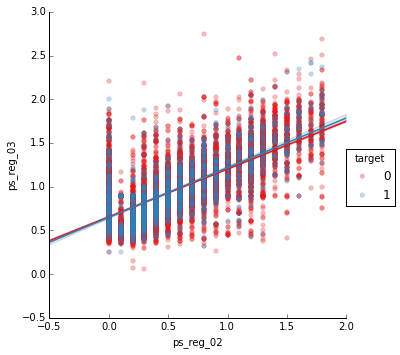

In [22]:
s = train.sample(frac=0.1)
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

其中，蓝线拟合target=1时，ps_reg_02与ps_reg_03的关系；红线拟合target=0时，ps_reg_02与ps_reg_03的关系；

#### ps_car_12 and ps_car_13

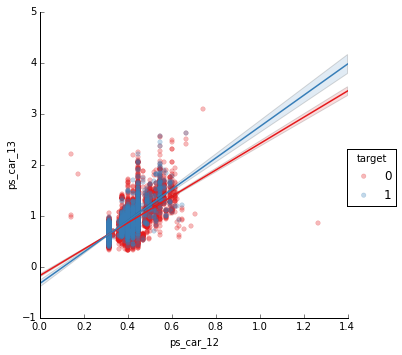

In [23]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

##### ps_car_12 and ps_car_14

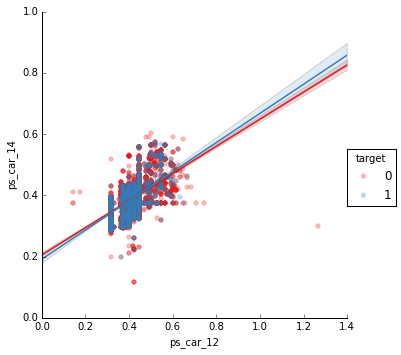

In [24]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

#### ps_car_13 and ps_car_15

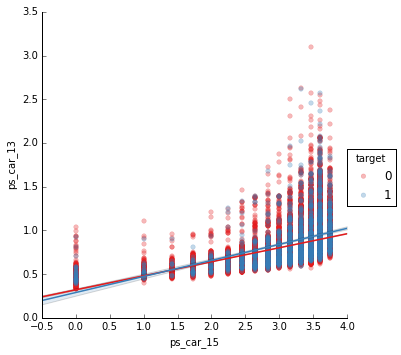

In [25]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

从上面可以进步查看特征之间的关联性，但是并不能确定到底保留哪些特征。一种处理方式是用PCA做特征提取，但是特征太少，不便于处理。暂时不作处理。...

# 特征工程

## 创建哑变量

因为第一个取值可以有其他值表示，所以drop_first=True

In [28]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 109 variables in train


这一过程，给训练集增加了52个变量


## 特征组合


In [29]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
# Merge the interaction variables to the train data
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, pd.DataFrame(data=interactions, columns=poly.get_feature_names(v))], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 variables in train
After creating interactions we have 174 variables in train


这一过程，给训练集增加了65个变量

In [30]:
train.columns

Index([u'id', u'target', u'ps_ind_01', u'ps_ind_03', u'ps_ind_06_bin',
       u'ps_ind_07_bin', u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin',
       u'ps_ind_11_bin',
       ...
       u'ps_car_15^2', u'ps_car_15 ps_calc_01', u'ps_car_15 ps_calc_02',
       u'ps_car_15 ps_calc_03', u'ps_calc_01^2', u'ps_calc_01 ps_calc_02',
       u'ps_calc_01 ps_calc_03', u'ps_calc_02^2', u'ps_calc_02 ps_calc_03',
       u'ps_calc_03^2'],
      dtype='object', length=174)

##  特征选择

### 剔除方差为零或过小的特征

这里，剔除方差小于1%的特征

In [31]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

30 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_tm', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12', 'ps_car_14', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


当前，在这次比赛中，我们可用的特征非常少，所以，特征选择的工作让分类器处理会比较合适，以免人为造成重要特征被剔除。

如果特征数特别多，使用这种方法可以有效降低模型整体运行耗时。

## 查看特征重要性

In [34]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_12 ps_car_13            0.016366
 2) ps_reg_01 ps_car_13            0.016014
 3) ps_reg_03 ps_car_13            0.015975
 4) ps_car_13                      0.015874
 5) ps_car_13^2                    0.015850
 6) ps_car_13                      0.015824
 7) ps_car_13 ps_car_14            0.015754
 8) ps_car_13 ps_car_15            0.015497
 9) ps_reg_03 ps_car_14            0.014991
10) ps_reg_03 ps_car_12            0.014348
11) ps_reg_03 ps_car_15            0.014320
12) ps_car_13 ps_calc_01           0.014043
13) ps_car_13 ps_calc_02           0.013983
14) ps_car_14 ps_car_15            0.013927
15) ps_car_13 ps_calc_03           0.013769
16) ps_reg_01 ps_reg_03            0.013722
17) ps_reg_02 ps_car_13            0.013620
18) ps_reg_01 ps_car_14            0.013395
19) ps_reg_03^2                    0.013200
20) ps_calc_10                     0.013181
21) ps_reg_03                      0.013139
22) ps_calc_14                     0.012963
23) ps_reg_03                   

In [ ]:
#使用模型做特征选择
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])
train = train[selected_vars + ['target']]

如上所述，对特征进行归一化

In [26]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.90494248, -0.45941104, -0.54103958, ..., -0.73248403,
         2.34451822, -0.22304206],
       [-1.34385673, -0.45941104,  0.96226006, ..., -0.73248403,
        -0.42652686, -0.22304206],
       [ 1.42556589,  1.55538958, -0.54103958, ...,  1.36521748,
        -0.42652686, -0.22304206],
       ..., 
       [ 1.63700344,  0.04428911, -0.54103958, ..., -0.73248403,
        -0.42652686,  0.81045677],
       [ 1.69140389,  0.04428911, -0.54103958, ...,  1.36521748,
        -0.42652686,  0.81045677],
       [ 1.69498651,  1.55538958, -0.54103958, ..., -0.73248403,
        -0.42652686,  0.81045677]])